In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p


from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet 
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor

In [39]:
# Load data: train and test sets

train_h = pd.read_csv('train_houses.csv', delimiter = ',', header = 0)
print(train_h.head())

test_h = pd.read_csv('test_houses.csv', delimiter = ',', header = 0)
print(test_h.head())
test_h['SalePrice'] = 'Unknown'

# Concatenate train and test sets into /combined/ for overall data transformation
combined = pd.concat([train_h,test_h], axis =0)
combined = combined.reset_index(drop=True)
print(combined.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [40]:
# Working with train set: define how many columns with non-numeric data types are in the table

non_numeric = 0
for elem in train_h.dtypes:  # I test train_h table, combined has the SalePrice columns not fully numeric
    if elem != 'int64' and elem != 'float64':
        non_numeric += 1
print(non_numeric)

print(np.unique(list(train_h.dtypes))) # What datatypes are in the table?  

43
[dtype('int64') dtype('float64') dtype('O')]


Divide non-numeric data features by themes, and map

1)'MSZoning', 'Neighborhood'
2) 'Street', 'Alley'
3) 'LotShape', 'LandContour', 'LotConfig', 'LandSlope'
4) 'Utilities', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical'
5) 'Condition1', 'Condition2'
6) 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
'ExterCond', 'Foundation', 'Functional' 
7) 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'
8)'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'
9) 'KitchenQual'
10) 'FireplaceQu'
11)'PavedDrive'
12)'PoolQC'
13)'Fence' 
14)'MiscFeature'
15)'SaleType', 'SaleCondition'

In [41]:
# plot_map function will visualize the relationship between feature/s of interest and target - SalePrice

def plot_map(features, descriptions,data):
    for col in zip(features,descriptions):
        print('Now plotting:', col[1], 'against SalePrice')

        sorted_set = data[[col[0], 'SalePrice']].groupby(col[0]).median()
        sorted_set = sorted_set.sort_values(['SalePrice'], axis =0, ascending = True)
        sorted_set = sorted_set.reset_index()
        
        if len(sorted_set) <= 5:
            plt.figure(figsize=(6,5))
        else:
            plt.figure(figsize=(8,7))
            
        sns.barplot(x=col[0], y ='SalePrice', data = sorted_set)
        if len(sorted_set) > 5:
            plt.xticks(rotation=90)
                
        plt.title(col[1]+' vs SalePrice')
        plt.show()

        sorted_set['rank'] = list(range(0,len(sorted_set)))
        mapped_set = dict(zip(list(sorted_set[col[0]]),list(sorted_set['rank'])))
        combined[col[0]] = combined[col[0]].map(mapped_set)
        print(mapped_set)

Now plotting: General zoning classification against SalePrice


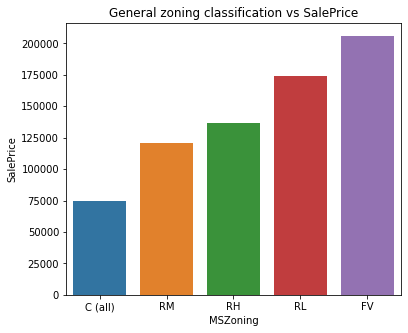

{'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}
Now plotting: Neighborhood against SalePrice


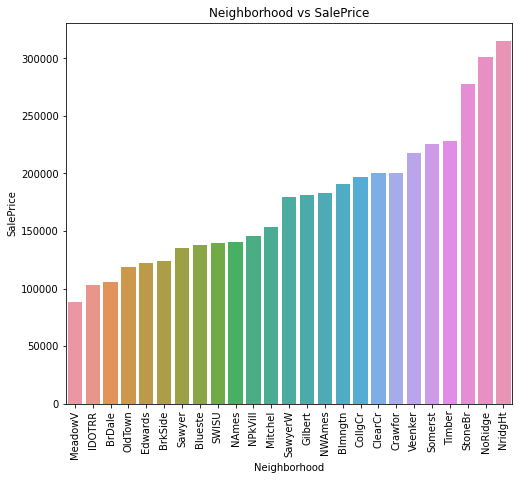

{'MeadowV': 0, 'IDOTRR': 1, 'BrDale': 2, 'OldTown': 3, 'Edwards': 4, 'BrkSide': 5, 'Sawyer': 6, 'Blueste': 7, 'SWISU': 8, 'NAmes': 9, 'NPkVill': 10, 'Mitchel': 11, 'SawyerW': 12, 'Gilbert': 13, 'NWAmes': 14, 'Blmngtn': 15, 'CollgCr': 16, 'ClearCr': 17, 'Crawfor': 18, 'Veenker': 19, 'Somerst': 20, 'Timber': 21, 'StoneBr': 22, 'NoRidge': 23, 'NridgHt': 24}


In [42]:
# 1)'MSZoning', 'Neighborhood'
# Visualize the relationship b/w ['MSZoning', 'Neighborhood'] and SalePrice

plot_map(['MSZoning','Neighborhood'],['General zoning classification','Neighborhood'], train_h)

Now plotting: Type of road access to property against SalePrice


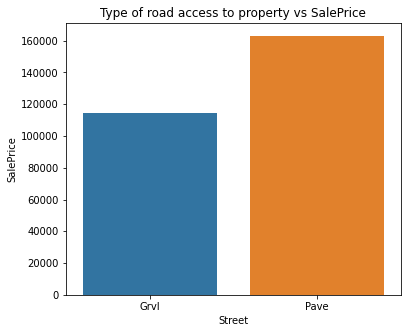

{'Grvl': 0, 'Pave': 1}
Now plotting: Type of alley access to property against SalePrice


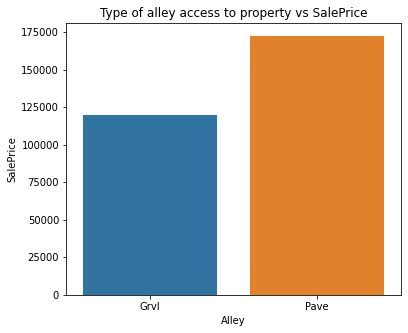

{'Grvl': 0, 'Pave': 1}


In [43]:
# 2) 'Street', 'Alley'

# Street: Type of road access to property
#        Grvl	Gravel	
#        Pave	Paved
# Alley: Type of alley access to property
#       Grvl	Gravel
#        Pave	Paved
#        NA 	No alley access

# Visualize the relationship b/w ['Street', 'Alley'] and SalePrice 
plot_map(['Street', 'Alley'],['Type of road access to property', 'Type of alley access to property'],train_h)


Now plotting: General shape of property against SalePrice


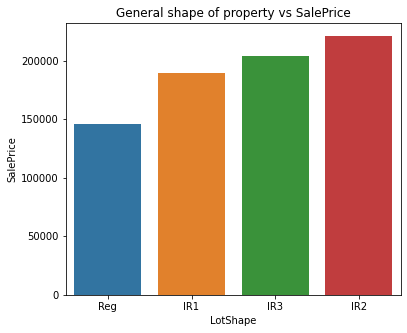

{'Reg': 0, 'IR1': 1, 'IR3': 2, 'IR2': 3}
Now plotting: Flatness of the property against SalePrice


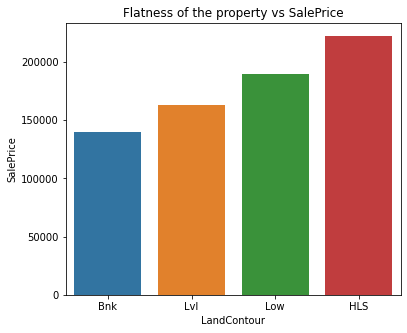

{'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}
Now plotting: Lot configuration against SalePrice


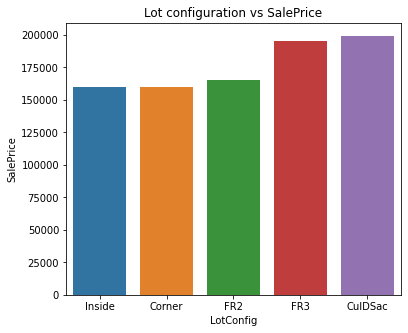

{'Inside': 0, 'Corner': 1, 'FR2': 2, 'FR3': 3, 'CulDSac': 4}
Now plotting: Slope of property against SalePrice


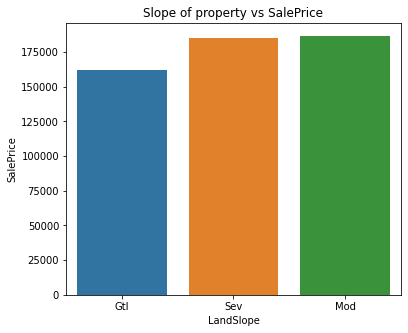

{'Gtl': 0, 'Sev': 1, 'Mod': 2}


In [44]:
# 3) 'LotShape', 'LandContour', 'LotConfig', 'LandSlope'
# Visualize the relationship b/w ['LotShape', 'LandContour', 'LotConfig', 'LandSlope'] and SalePrice:

# LotShape: General shape of property
#        Reg	Regular	

#        IR1	Slightly irregular

#        IR2	Moderately Irregular

#        IR3	Irregular

# LandContour: Flatness of the property
#        Lvl	Near Flat/Level	

#        Bnk	Banked - Quick and significant rise from street grade to building

#        HLS	Hillside - Significant slope from side to side

#        Low	Depression

# LotConfig: Lot configuration
#        Inside	Inside lot

#        Corner	Corner lot

#        CulDSac	Cul-de-sac

#        FR2	Frontage on 2 sides of property

#        FR3	Frontage on 3 sides of property

# LandSlope: Slope of property
#        Gtl	Gentle slope

#        Mod	Moderate Slope	

#        Sev	Severe Slope

plot_map(['LotShape', 'LandContour', 'LotConfig', 'LandSlope'],\
         ['General shape of property','Flatness of the property','Lot configuration','Slope of property'],\
         train_h)

Now plotting: Type of utilities available against SalePrice


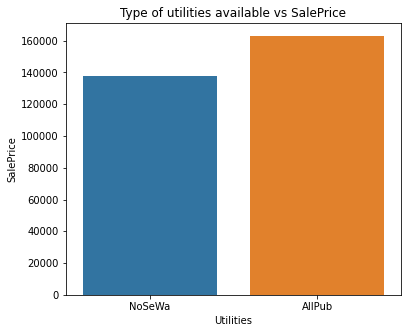

{'NoSeWa': 0, 'AllPub': 1}
Now plotting: Type of heating against SalePrice


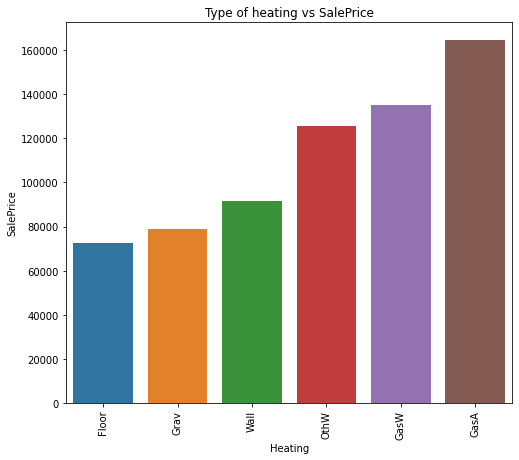

{'Floor': 0, 'Grav': 1, 'Wall': 2, 'OthW': 3, 'GasW': 4, 'GasA': 5}
Now plotting: Heating quality and condition against SalePrice


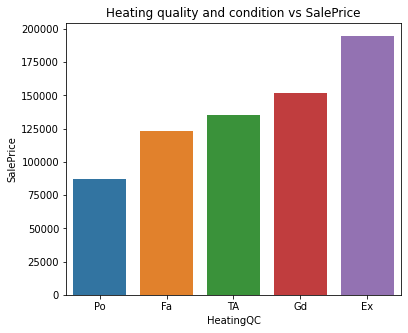

{'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
Now plotting: Central air conditioning against SalePrice


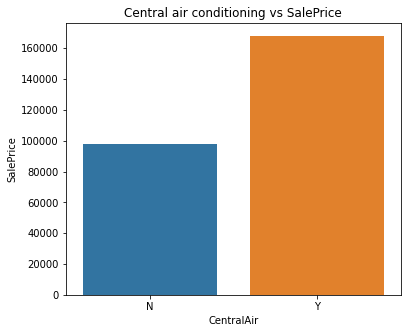

{'N': 0, 'Y': 1}
Now plotting: Electrical system against SalePrice


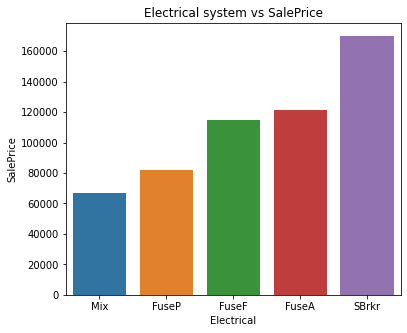

{'Mix': 0, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr': 4}


In [45]:
# 4) 'Utilities','Heating', 'HeatingQC', 'CentralAir', 'Electrical'
# Visualize the relationship b/w ['Utilities','Heating', 'HeatingQC', 'CentralAir', 'Electrical'] and SalePrice:

# Utilities: Type of utilities available


#        AllPub	All public Utilities (E,G,W,& S)	

#        NoSewr	Electricity, Gas, and Water (Septic Tank)

#        NoSeWa	Electricity and Gas Only

#        ELO	Electricity only	
        
# Heating: Type of heating


#        Floor	Floor Furnace

#        GasA	Gas forced warm air furnace

#        GasW	Gas hot water or steam heat

#        Grav	Gravity furnace	

#        OthW	Hot water or steam heat other than gas

#        Wall	Wall furnace


# HeatingQC: Heating quality and condition



#        Ex	Excellent

#        Gd	Good

#        TA	Average/Typical

#        Fa	Fair

#        Po	Poor


# CentralAir: Central air conditioning



#        N	No

#        Y	Yes


# Electrical: Electrical system



#        SBrkr	Standard Circuit Breakers & Romex

#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	

#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)

#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)

#        Mix	Mixed

plot_map(['Utilities','Heating', 'HeatingQC', 'CentralAir', 'Electrical'],\
        ['Type of utilities available','Type of heating', 'Heating quality and condition',\
                'Central air conditioning','Electrical system'], train_h)

Now plotting: Proximity to various conditions against SalePrice


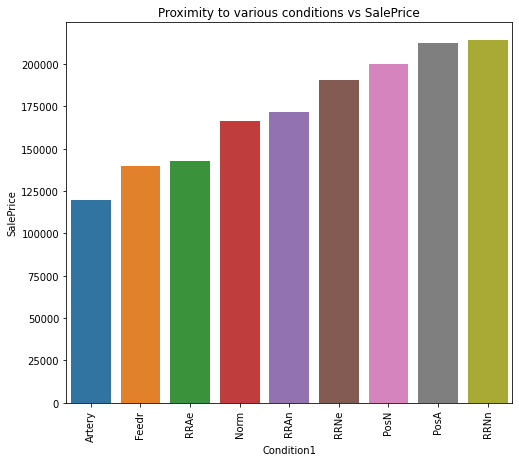

{'Artery': 0, 'Feedr': 1, 'RRAe': 2, 'Norm': 3, 'RRAn': 4, 'RRNe': 5, 'PosN': 6, 'PosA': 7, 'RRNn': 8}
Now plotting: Proximity to various conditions(2) against SalePrice


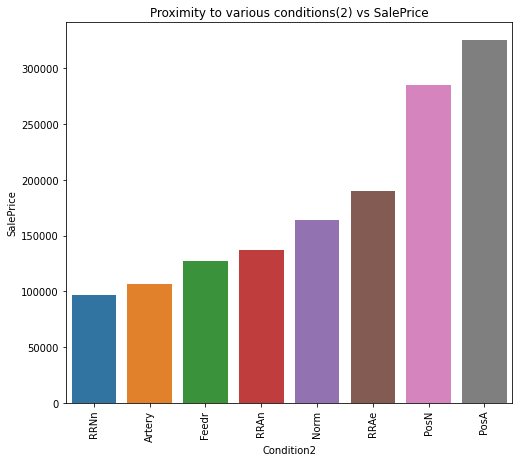

{'RRNn': 0, 'Artery': 1, 'Feedr': 2, 'RRAn': 3, 'Norm': 4, 'RRAe': 5, 'PosN': 6, 'PosA': 7}


In [46]:
# 5) 'Condition1', 'Condition2'

# Condition1: Proximity to various conditions


#        Artery	Adjacent to arterial street

#        Feedr	Adjacent to feeder street	

#        Norm	Normal	

#        RRNn	Within 200' of North-South Railroad

#        RRAn	Adjacent to North-South Railroad

#        PosN	Near positive off-site feature--park, greenbelt, etc.

#        PosA	Adjacent to postive off-site feature

#        RRNe	Within 200' of East-West Railroad

#        RRAe	Adjacent to East-West Railroad


# Condition2: Proximity to various conditions (if more than one is present)


#        Artery	Adjacent to arterial street

#        Feedr	Adjacent to feeder street	

#        Norm	Normal	

#        RRNn	Within 200' of North-South Railroad

#        RRAn	Adjacent to North-South Railroad

#        PosN	Near positive off-site feature--park, greenbelt, etc.

#        PosA	Adjacent to postive off-site feature

#        RRNe	Within 200' of East-West Railroad

#        RRAe	Adjacent to East-West Railroad

plot_map(['Condition1', 'Condition2'],\
               ['Proximity to various conditions','Proximity to various conditions(2)'], train_h)

Now plotting: Type of dwelling against SalePrice


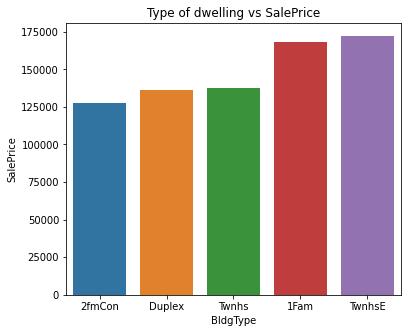

{'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4}
Now plotting: Style of dwelling against SalePrice


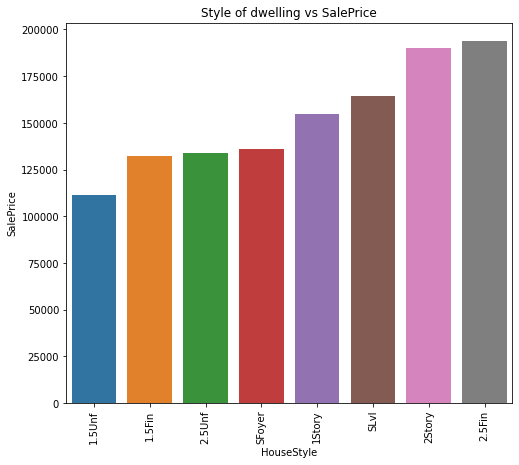

{'1.5Unf': 0, '1.5Fin': 1, '2.5Unf': 2, 'SFoyer': 3, '1Story': 4, 'SLvl': 5, '2Story': 6, '2.5Fin': 7}
Now plotting: Type of roof against SalePrice


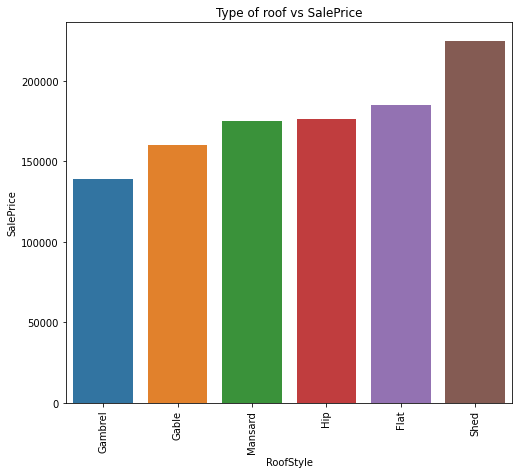

{'Gambrel': 0, 'Gable': 1, 'Mansard': 2, 'Hip': 3, 'Flat': 4, 'Shed': 5}
Now plotting: Roof material against SalePrice


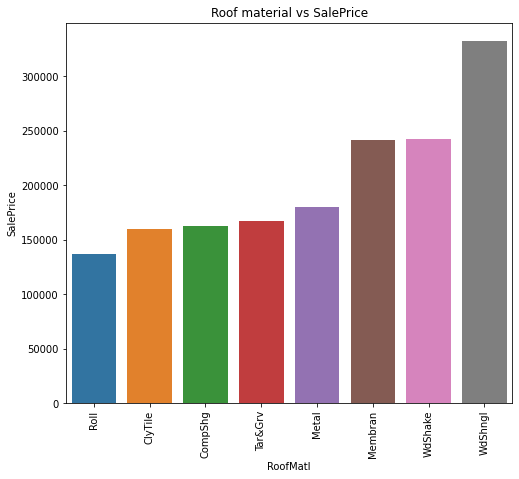

{'Roll': 0, 'ClyTile': 1, 'CompShg': 2, 'Tar&Grv': 3, 'Metal': 4, 'Membran': 5, 'WdShake': 6, 'WdShngl': 7}
Now plotting: Exterior covering on house against SalePrice


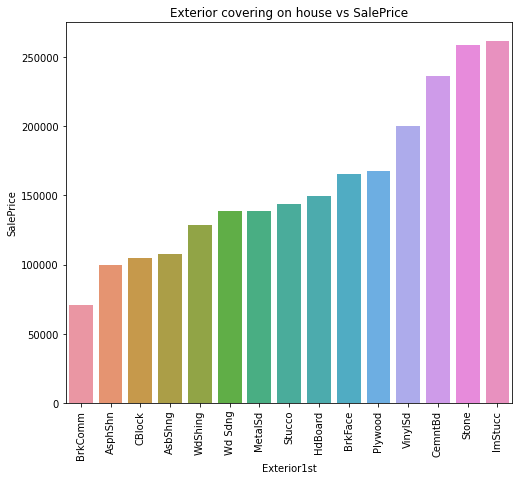

{'BrkComm': 0, 'AsphShn': 1, 'CBlock': 2, 'AsbShng': 3, 'WdShing': 4, 'Wd Sdng': 5, 'MetalSd': 6, 'Stucco': 7, 'HdBoard': 8, 'BrkFace': 9, 'Plywood': 10, 'VinylSd': 11, 'CemntBd': 12, 'Stone': 13, 'ImStucc': 14}
Now plotting: Exterior covering on house(2) against SalePrice


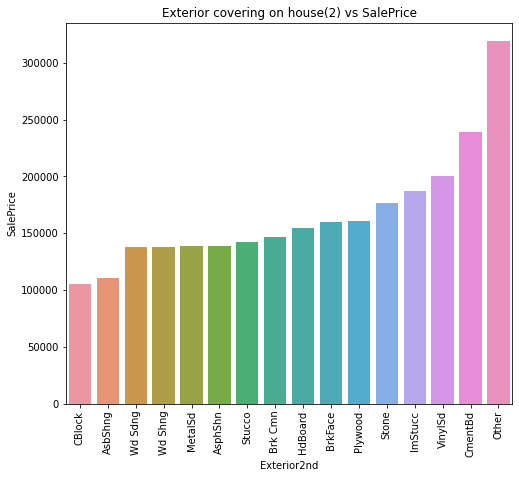

{'CBlock': 0, 'AsbShng': 1, 'Wd Sdng': 2, 'Wd Shng': 3, 'MetalSd': 4, 'AsphShn': 5, 'Stucco': 6, 'Brk Cmn': 7, 'HdBoard': 8, 'BrkFace': 9, 'Plywood': 10, 'Stone': 11, 'ImStucc': 12, 'VinylSd': 13, 'CmentBd': 14, 'Other': 15}
Now plotting: Masonry veneer type against SalePrice


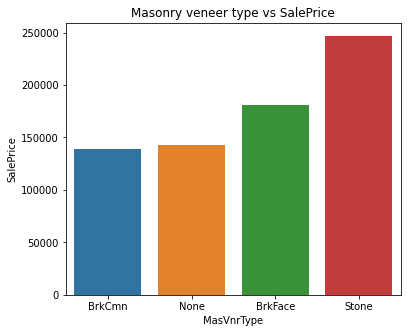

{'BrkCmn': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3}
Now plotting: Quality of the material on the exterior  against SalePrice


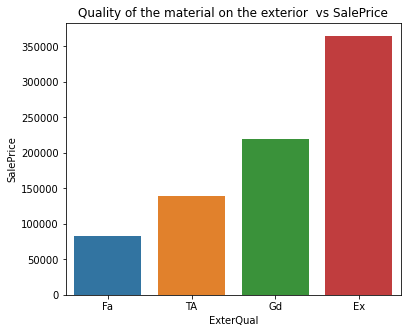

{'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
Now plotting: Condition of the material on the exterior against SalePrice


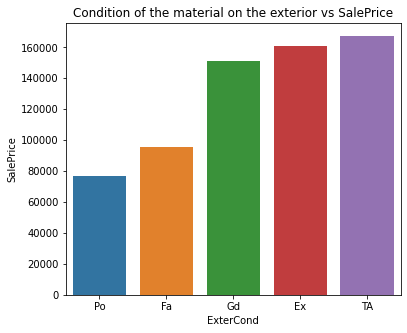

{'Po': 0, 'Fa': 1, 'Gd': 2, 'Ex': 3, 'TA': 4}
Now plotting: Type of foundation against SalePrice


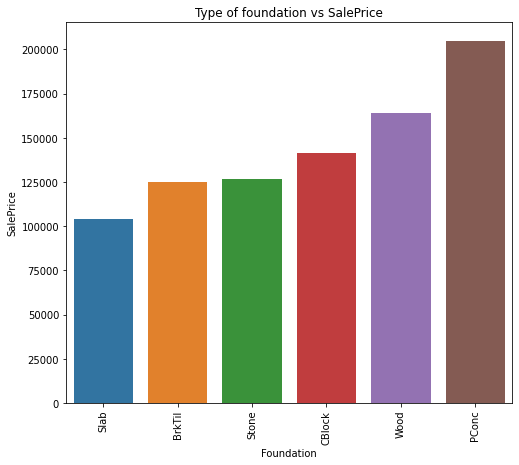

{'Slab': 0, 'BrkTil': 1, 'Stone': 2, 'CBlock': 3, 'Wood': 4, 'PConc': 5}
Now plotting: Home functionality against SalePrice


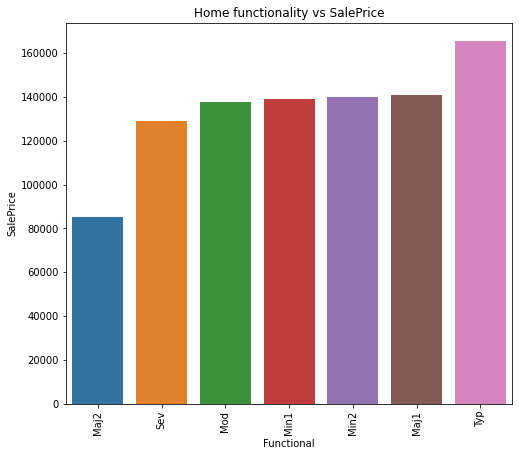

{'Maj2': 0, 'Sev': 1, 'Mod': 2, 'Min1': 3, 'Min2': 4, 'Maj1': 5, 'Typ': 6}


In [47]:
# 6) 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
# 'ExterCond', 'Foundation', 'Functional'

# Visualize the relationship b/w ['BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
# 'ExterCond', 'Foundation', 'Functional'] and SalePrice:


# BldgType: Type of dwelling


#        1Fam	Single-family Detached	

#        2FmCon	Two-family Conversion; originally built as one-family dwelling

#        Duplx	Duplex

#        TwnhsE	Townhouse End Unit

#        TwnhsI	Townhouse Inside Unit


# HouseStyle: Style of dwelling


#        1Story	One story

#        1.5Fin	One and one-half story: 2nd level finished

#        1.5Unf	One and one-half story: 2nd level unfinished

#        2Story	Two story

#        2.5Fin	Two and one-half story: 2nd level finished

#        2.5Unf	Two and one-half story: 2nd level unfinished

#        SFoyer	Split Foyer

#        SLvl	Split Level


# RoofStyle: Type of roof


#        Flat	Flat

#        Gable	Gable

#        Gambrel	Gabrel (Barn)

#        Hip	Hip

#        Mansard	Mansard

#        Shed	Shed


# RoofMatl: Roof material


#        ClyTile	Clay or Tile

#        CompShg	Standard (Composite) Shingle

#        Membran	Membrane

#        Metal	Metal

#        Roll	Roll

#        Tar&Grv	Gravel & Tar

#        WdShake	Wood Shakes

#        WdShngl	Wood Shingles


# Exterior1st: Exterior covering on house


#        AsbShng	Asbestos Shingles

#        AsphShn	Asphalt Shingles

#        BrkComm	Brick Common

#        BrkFace	Brick Face

#        CBlock	Cinder Block

#        CemntBd	Cement Board

#        HdBoard	Hard Board

#        ImStucc	Imitation Stucco

#        MetalSd	Metal Siding

#        Other	Other

#        Plywood	Plywood

#        PreCast	PreCast	

#        Stone	Stone

#        Stucco	Stucco

#        VinylSd	Vinyl Siding

#        Wd Sdng	Wood Siding

#        WdShing	Wood Shingles


# Exterior2nd: Exterior covering on house (if more than one material)


#        AsbShng	Asbestos Shingles

#        AsphShn	Asphalt Shingles

#        BrkComm	Brick Common

#        BrkFace	Brick Face

#        CBlock	Cinder Block

#        CemntBd	Cement Board

#        HdBoard	Hard Board

#        ImStucc	Imitation Stucco

#        MetalSd	Metal Siding

#        Other	Other

#        Plywood	Plywood

#        PreCast	PreCast

#        Stone	Stone

#        Stucco	Stucco

#        VinylSd	Vinyl Siding

#        Wd Sdng	Wood Siding

#        WdShing	Wood Shingles


# MasVnrType: Masonry veneer type


#        BrkCmn	Brick Common

#        BrkFace	Brick Face

#        CBlock	Cinder Block

#        None	None

#        Stone	Stone


# ExterQual: Evaluates the quality of the material on the exterior 


#        Ex	Excellent

#        Gd	Good

#        TA	Average/Typical

#        Fa	Fair

#        Po	Poor


# ExterCond: Evaluates the present condition of the material on the exterior


#        Ex	Excellent

#        Gd	Good

#        TA	Average/Typical

#        Fa	Fair

#        Po	Poor


# Foundation: Type of foundation


#        BrkTil	Brick & Tile

#        CBlock	Cinder Block

#        PConc	Poured Contrete	

#        Slab	Slab

#        Stone	Stone

#        Wood	Wood

# Functional: Home functionality (Assume typical unless deductions are warranted)



#        Typ	Typical Functionality

#        Min1	Minor Deductions 1

#        Min2	Minor Deductions 2

#        Mod	Moderate Deductions

#        Maj1	Major Deductions 1

#        Maj2	Major Deductions 2

#        Sev	Severely Damaged

#        Sal	Salvage only

plot_map(['BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',\
            'ExterQual', 'ExterCond', 'Foundation', 'Functional'],\
               ['Type of dwelling','Style of dwelling','Type of roof','Roof material','Exterior covering on house',\
                'Exterior covering on house(2)','Masonry veneer type','Quality of the material on the exterior ',\
                'Condition of the material on the exterior','Type of foundation','Home functionality'], train_h)

Now plotting: Height of the basement against SalePrice


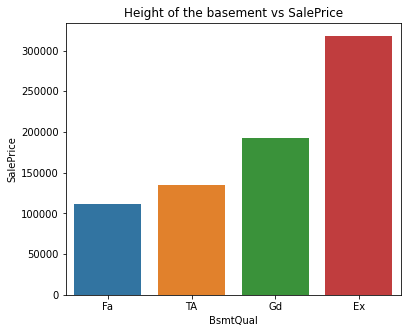

{'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
Now plotting: General condition of the basement against SalePrice


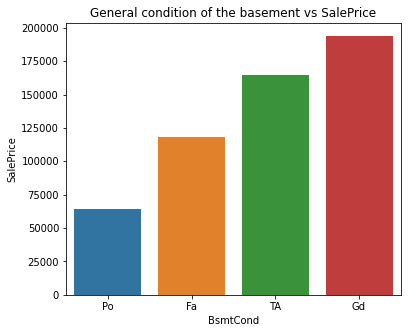

{'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3}
Now plotting: Walkout or garden level walls against SalePrice


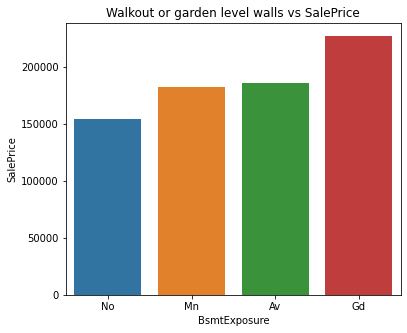

{'No': 0, 'Mn': 1, 'Av': 2, 'Gd': 3}
Now plotting: Rating of basement finished area against SalePrice


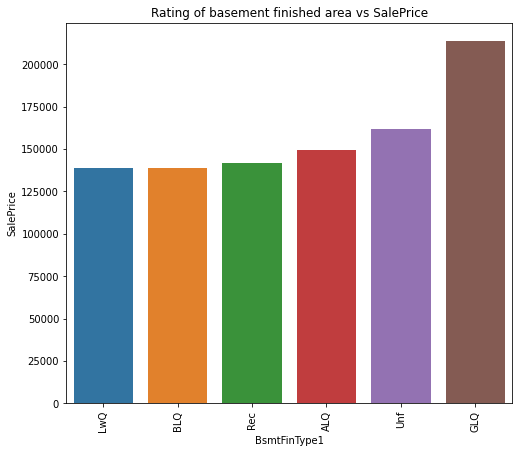

{'LwQ': 0, 'BLQ': 1, 'Rec': 2, 'ALQ': 3, 'Unf': 4, 'GLQ': 5}
Now plotting: Rating of basement finished area(2) against SalePrice


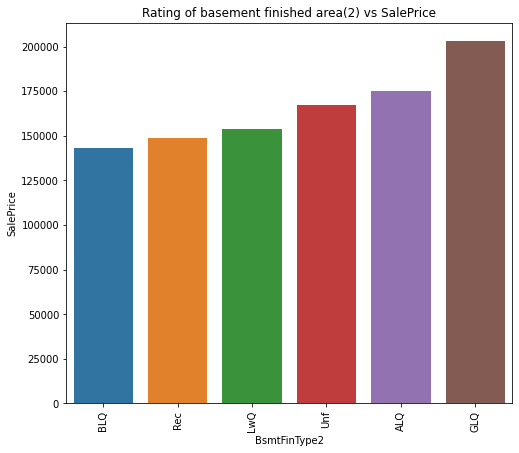

{'BLQ': 0, 'Rec': 1, 'LwQ': 2, 'Unf': 3, 'ALQ': 4, 'GLQ': 5}


In [48]:
# 7) 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'
# Visualize the relationship b/w ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
# and SalePrice:

# BsmtQual: Evaluates the height of the basement


#        Ex	Excellent (100+ inches)	

#        Gd	Good (90-99 inches)

#        TA	Typical (80-89 inches)

#        Fa	Fair (70-79 inches)

#        Po	Poor (<70 inches

#        NA	No Basement


# BsmtCond: Evaluates the general condition of the basement


#        Ex	Excellent

#        Gd	Good

#        TA	Typical - slight dampness allowed

#        Fa	Fair - dampness or some cracking or settling

#        Po	Poor - Severe cracking, settling, or wetness

#        NA	No Basement


# BsmtExposure: Refers to walkout or garden level walls


#        Gd	Good Exposure

#        Av	Average Exposure (split levels or foyers typically score average or above)	

#        Mn	Mimimum Exposure

#        No	No Exposure

#        NA	No Basement



# BsmtFinType1: Rating of basement finished area


#        GLQ	Good Living Quarters

#        ALQ	Average Living Quarters

#        BLQ	Below Average Living Quarters	

#        Rec	Average Rec Room

#        LwQ	Low Quality

#        Unf	Unfinshed

#        NA	No Basement


# BsmtFinType2: Rating of basement finished area (if multiple types)


#        GLQ	Good Living Quarters

#        ALQ	Average Living Quarters

#        BLQ	Below Average Living Quarters	

#        Rec	Average Rec Room

#        LwQ	Low Quality

#        Unf	Unfinshed

#        NA	No Basement



# Visualize the relationship b/w the feature and SalePrice:
plot_map(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'],\
              ['Height of the basement','General condition of the basement','Walkout or garden level walls',\
               'Rating of basement finished area','Rating of basement finished area(2)'],train_h)

Now plotting: Garage location against SalePrice


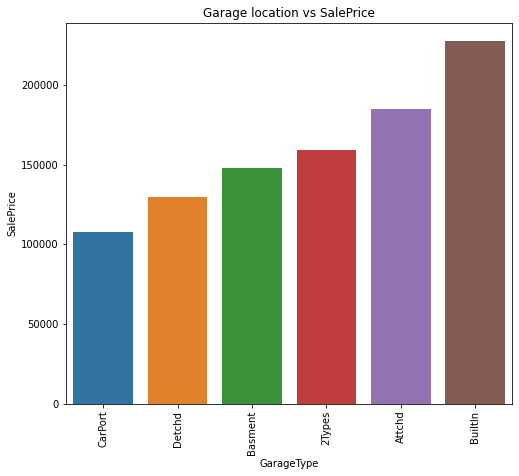

{'CarPort': 0, 'Detchd': 1, 'Basment': 2, '2Types': 3, 'Attchd': 4, 'BuiltIn': 5}
Now plotting: Interior finish of the garage against SalePrice


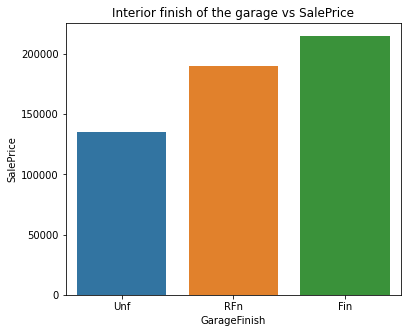

{'Unf': 0, 'RFn': 1, 'Fin': 2}
Now plotting: Garage quality against SalePrice


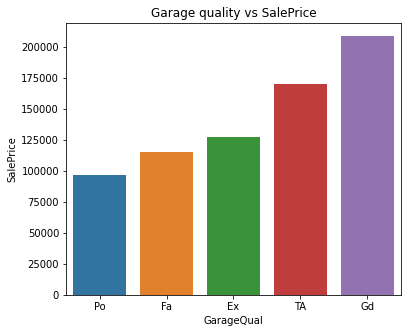

{'Po': 0, 'Fa': 1, 'Ex': 2, 'TA': 3, 'Gd': 4}
Now plotting: Garage condition against SalePrice


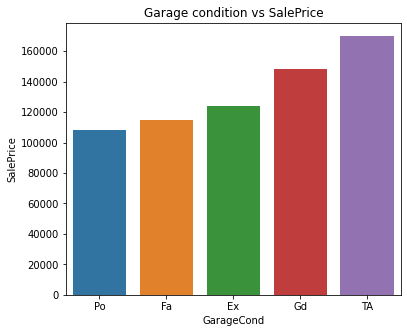

{'Po': 0, 'Fa': 1, 'Ex': 2, 'Gd': 3, 'TA': 4}


In [49]:
# 8)'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'
# Visualize the relationship b/w ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'] and SalePrice:

# GarageType: Garage location


#        2Types	More than one type of garage

#        Attchd	Attached to home

#        Basment	Basement Garage

#        BuiltIn	Built-In (Garage part of house - typically has room above garage)

#        CarPort	Car Port

#        Detchd	Detached from home

#        NA	No Garage


# GarageFinish: Interior finish of the garage


#        Fin	Finished

#        RFn	Rough Finished	

#        Unf	Unfinished

#        NA	No Garage



# GarageQual: Garage quality


#        Ex	Excellent

#        Gd	Good

#        TA	Typical/Average

#        Fa	Fair

#        Po	Poor

#        NA	No Garage



# GarageCond: Garage condition


#        Ex	Excellent

#        Gd	Good

#        TA	Typical/Average

#        Fa	Fair

#        Po	Poor

#        NA	No Garage

plot_map(['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'],\
              ['Garage location','Interior finish of the garage','Garage quality','Garage condition'],train_h)

Now plotting: Kitchen quality against SalePrice


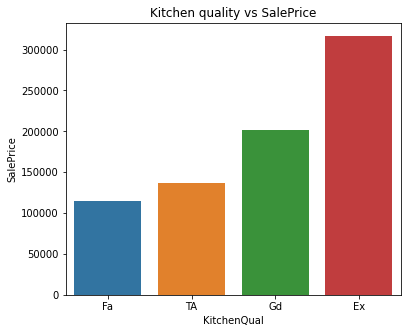

{'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
Now plotting: Fireplace quality against SalePrice


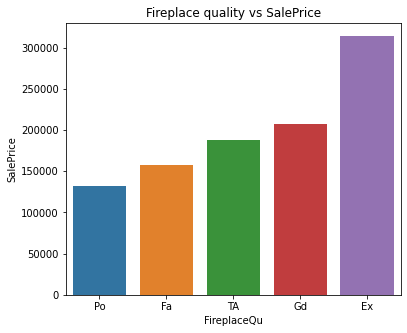

{'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
Now plotting: Paved driveway against SalePrice


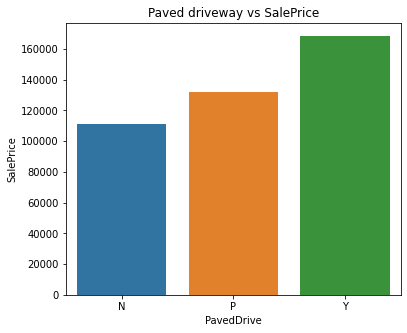

{'N': 0, 'P': 1, 'Y': 2}
Now plotting: Pool quality against SalePrice


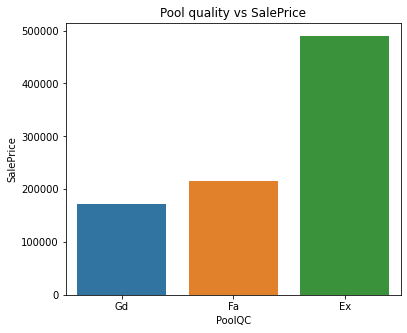

{'Gd': 0, 'Fa': 1, 'Ex': 2}
Now plotting: Fence quality against SalePrice


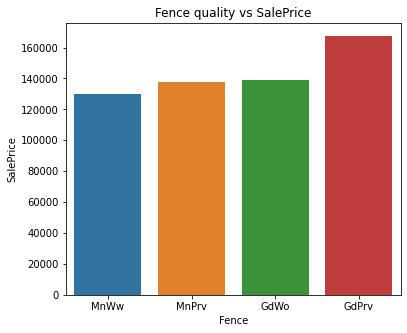

{'MnWw': 0, 'MnPrv': 1, 'GdWo': 2, 'GdPrv': 3}
Now plotting: Miscellaneous feature against SalePrice


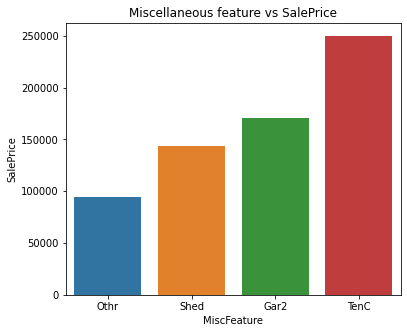

{'Othr': 0, 'Shed': 1, 'Gar2': 2, 'TenC': 3}


In [50]:
# 9) 'KitchenQual'
# 10) 'FireplaceQu'
# 11)'PavedDrive'
# 12)'PoolQC'
# 13)'Fence' 
# 14)'MiscFeature'

# # Visualize the relationship b/w ['KitchenQual', 'FireplaceQu', 'PavedDrive', 'PoolQC','Fence','MiscFeature']
# and SalePrice:

# KitchenQual: Kitchen quality


#        Ex	Excellent

#        Gd	Good

#        TA	Typical/Average

#        Fa	Fair

#        Po	Poor


# FireplaceQu: Fireplace quality


#        Ex	Excellent - Exceptional Masonry Fireplace

#        Gd	Good - Masonry Fireplace in main level

#        TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement

#        Fa	Fair - Prefabricated Fireplace in basement

#        Po	Poor - Ben Franklin Stove

#        NA	No Fireplace


# PavedDrive: Paved driveway


#        Y	Paved 

#        P	Partial Pavement

#        N	Dirt/Gravel


# PoolQC: Pool quality



#        Ex	Excellent

#        Gd	Good

#        TA	Average/Typical

#        Fa	Fair

#        NA	No Pool



# Fence: Fence quality



#        GdPrv	Good Privacy

#        MnPrv	Minimum Privacy

#        GdWo	Good Wood

#        MnWw	Minimum Wood/Wire

#        NA	No Fence



# MiscFeature: Miscellaneous feature not covered in other categories



#        Elev	Elevator

#        Gar2	2nd Garage (if not described in garage section)

#        Othr	Other

#        Shed	Shed (over 100 SF)

#        TenC	Tennis Court

#        NA	None
        
plot_map(['KitchenQual', 'FireplaceQu', 'PavedDrive', 'PoolQC','Fence','MiscFeature'],\
             ['Kitchen quality','Fireplace quality', 'Paved driveway', 'Pool quality',\
             'Fence quality','Miscellaneous feature'], train_h)

Now plotting: Type of sale against SalePrice


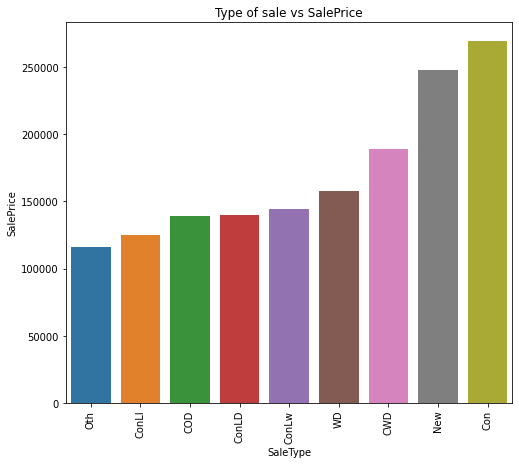

{'Oth': 0, 'ConLI': 1, 'COD': 2, 'ConLD': 3, 'ConLw': 4, 'WD': 5, 'CWD': 6, 'New': 7, 'Con': 8}
Now plotting: Condition of sale against SalePrice


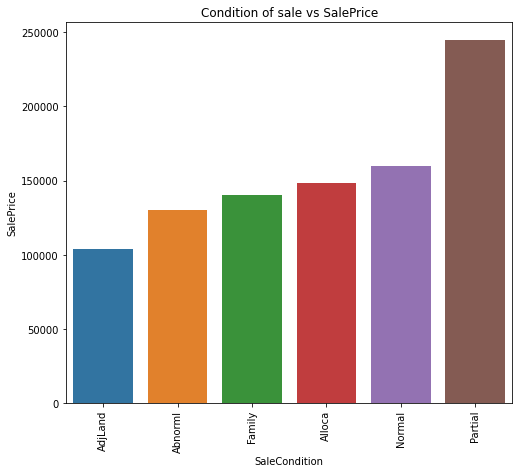

{'AdjLand': 0, 'Abnorml': 1, 'Family': 2, 'Alloca': 3, 'Normal': 4, 'Partial': 5}


In [51]:
# 15)'SaleType', 'SaleCondition'
# Visualize the relationship b/w ['SaleType', 'SaleCondition'] and SalePrice:

# SaleType: Type of sale

#        WD 	Warranty Deed - Conventional

#        CWD	Warranty Deed - Cash

#        VWD	Warranty Deed - VA Loan

#        New	Home just constructed and sold

#        COD	Court Officer Deed/Estate

#        Con	Contract 15% Down payment regular terms

#        ConLw	Contract Low Down payment and low interest

#        ConLI	Contract Low Interest

#        ConLD	Contract Low Down

#        Oth	Other


# SaleCondition: Condition of sale


#        Normal	Normal Sale

#        Abnorml	Abnormal Sale -  trade, foreclosure, short sale

#        AdjLand	Adjoining Land Purchase

#        Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	

#        Family	Sale between family members

#        Partial	Home was not completed when last assessed (associated with New Homes)

plot_map(['SaleType', 'SaleCondition'],\
             ['Type of sale','Condition of sale'],train_h)

In [52]:
# Check whether there are anymore columns with non-numeric values in /combined/
dict_dtype = dict(zip(combined.columns,combined.dtypes))

non_numeric = []
for key,val in dict_dtype.items():  
    if val != 'int64' and val != 'float64':
        non_numeric.append(key)
print(non_numeric)  # last column of the SalePrice is of object data type, since it contains both numeric and
                    # string data ('unknown' price for test set)
    

['SalePrice']


Filling out NaNs 

In [53]:
# Some of the columns contain nans but these nans are defined, informative, according to the legend below;
# replace these nans with logical numeric value.

# Alley NA 	No alley access, BsmtQual NA	No Basement...
# FireplaceQu   NA	No Fireplace, 'GarageType' NA	No Garage
# PoolQC NA	No Pool 
# Fence NA	No Fence
# MiscFeature NA	None

for col in ['Alley', 'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType',\
            'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']:
    combined[col] = pd.Series([i if pd.isnull(i)==0 else -1 for i in combined[col]])
    print(col)
    print(np.unique(list(combined[col])))
    print('\n')


Alley
[-1.  0.  1.]


BsmtQual
[-1.  0.  1.  2.  3.]


BsmtCond
[-1.  0.  1.  2.  3.]


BsmtExposure
[-1.  0.  1.  2.  3.]


BsmtFinType1
[-1.  0.  1.  2.  3.  4.  5.]


BsmtFinType2
[-1.  0.  1.  2.  3.  4.  5.]


FireplaceQu
[-1.  0.  1.  2.  3.  4.]


GarageType
[-1.  0.  1.  2.  3.  4.  5.]


GarageFinish
[-1.  0.  1.  2.]


GarageQual
[-1.  0.  1.  2.  3.  4.]


GarageCond
[-1.  0.  1.  2.  3.  4.]


PoolQC
[-1.  0.  1.  2.]


Fence
[-1.  0.  1.  2.  3.]


MiscFeature
[-1.  0.  1.  2.  3.]




In [54]:
# Add 1 to columns with nan mapped as -1, to avoid negative values; nans become new 0 and other categories start from 1

for col in ['Alley', 'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType',\
            'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']:
    combined[col] = combined[col]+1
    print(col)
    print(np.unique(list(combined[col])))
    print('\n')

Alley
[0. 1. 2.]


BsmtQual
[0. 1. 2. 3. 4.]


BsmtCond
[0. 1. 2. 3. 4.]


BsmtExposure
[0. 1. 2. 3. 4.]


BsmtFinType1
[0. 1. 2. 3. 4. 5. 6.]


BsmtFinType2
[0. 1. 2. 3. 4. 5. 6.]


FireplaceQu
[0. 1. 2. 3. 4. 5.]


GarageType
[0. 1. 2. 3. 4. 5. 6.]


GarageFinish
[0. 1. 2. 3.]


GarageQual
[0. 1. 2. 3. 4. 5.]


GarageCond
[0. 1. 2. 3. 4. 5.]


PoolQC
[0. 1. 2. 3.]


Fence
[0. 1. 2. 3. 4.]


MiscFeature
[0. 1. 2. 3. 4.]




In [56]:
# See what are the other columns with nans:

for col in combined.columns:
    print(col,np.where(pd.isnull(combined[col])==1), len(np.where(pd.isnull(combined[col])==1)[0]))

Id (array([], dtype=int64),) 0
MSSubClass (array([], dtype=int64),) 0
MSZoning (array([1915, 2216, 2250, 2904], dtype=int64),) 4
LotFrontage (array([   7,   12,   14,   16,   24,   31,   42,   43,   50,   64,   66,
         76,   84,   95,  100,  104,  111,  113,  116,  120,  126,  131,
        133,  136,  147,  149,  152,  153,  160,  166,  169,  170,  177,
        180,  186,  191,  203,  207,  208,  214,  218,  221,  234,  237,
        244,  249,  269,  287,  288,  293,  307,  308,  310,  319,  328,
        330,  335,  342,  346,  347,  351,  356,  360,  361,  364,  366,
        369,  370,  375,  384,  392,  393,  404,  405,  412,  421,  426,
        447,  452,  457,  458,  459,  465,  470,  484,  490,  496,  516,
        518,  529,  537,  538,  539,  541,  545,  559,  560,  564,  569,
        580,  593,  610,  611,  612,  616,  623,  626,  641,  645,  660,
        666,  668,  672,  679,  682,  685,  687,  690,  706,  709,  714,
        720,  721,  726,  734,  745,  746,  751,  757, 

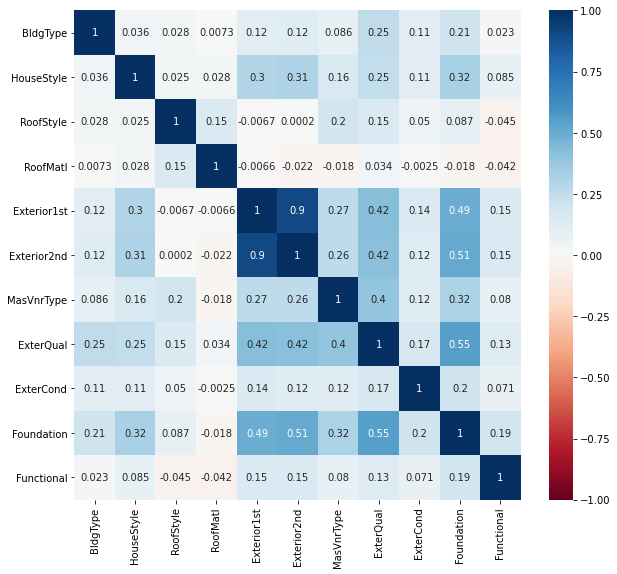

In [57]:
# Start with filling out nans in columns with multiple missing values; determine what features
# correlate with the columns of missing nans.

# Find what features are correlated with missing 'MasVnrType':

plt.figure(figsize=(10,9))
sns.heatmap(combined[['BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','ExterQual', 'ExterCond', 'Foundation', 'Functional']].corr(), annot = True, cmap = 'RdBu',
                xticklabels = True, vmin = -1, vmax = 1)
plt.show()

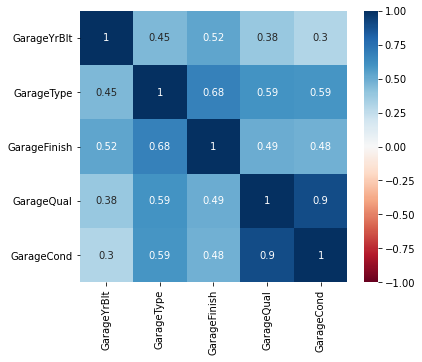

In [58]:
# find what features are correlated with missing 'GarageYrBlt':

plt.figure(figsize = (6,5))
sns.heatmap(combined[['GarageYrBlt','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].corr(), annot = True, cmap = 'RdBu',
                xticklabels = True, vmin = -1, vmax = 1)
plt.show()

In [59]:
# Filling out nans in columns with massively missing values (LotFrontage, MasVnrType, MasVnrArea, GarageYrBlt,
# using query subsets of matching correlating features.

# Filling out GarageYrBlt where the garage is missing ('GarageType' is former nan that's been mapped into 0)

GarageYrBlt_miss = list(np.where(pd.isnull(combined['GarageYrBlt'])==1)[0])
GarageType_miss = list(np.where(combined['GarageType'] == 0)[0])
print(len(GarageYrBlt_miss))
print(len(GarageType_miss))
shared = []
for one in GarageType_miss:
    if one in GarageYrBlt_miss:
        shared.append(one)
print(shared, len(shared))  # whatever is shared means that the GarageYrBlt is non-existent, 
                            # since there is no garage
combined.loc[shared,'GarageYrBlt'] = 0

# Filling out 'GarageYrBlt' for existing garages

GarageYrBlt_miss = list(np.where(pd.isnull(combined['GarageYrBlt'])==1)[0])
for row in GarageYrBlt_miss:    
    query_subset = combined[(combined['GarageType'] == combined.loc[row,'GarageType']) &\
                            (combined['GarageQual'] == combined.loc[row,'GarageQual']) &\
                            (combined['GarageCond'] == combined.loc[row,'GarageCond'])]                             
    
    if len(query_subset) < 10:
        combined.loc[row,'GarageYrBlt'] = np.nanmedian(combined.loc[:,'GarageYrBlt'].values)
    else:
        combined.loc[row,'GarageYrBlt'] = np.nanmedian(query_subset.loc[:,'GarageYrBlt'].values)


# Filling out 'MasVnrType' where there is a missing 'MasVnrArea'; filling out 0 where the area is missing

MasVnrType_missing = list(np.where(pd.isnull(combined['MasVnrType'])==1)[0])
MasVnrArea_missing = list(np.where(pd.isnull(combined['MasVnrArea'])==1)[0])
print(MasVnrType_missing, len(MasVnrType_missing))
print(MasVnrArea_missing, len(MasVnrArea_missing))

MasVnr_miss = list(set(MasVnrType_missing) & set(MasVnrArea_missing))
print(MasVnr_miss, len(MasVnr_miss))

for row in MasVnr_miss:
    combined.loc[row,'MasVnrType'] = -1  # reflects no MasVanType
    combined.loc[row,'MasVnrArea'] = 0 
combined['MasVnrType'] = combined['MasVnrType'] + 1  # shift all values up by 1 to avoid nefative values


# Filling out 'MasVnrType' where there is an area (nan values remaining after shared have been filled):
# Use features that correlate with missing 'MasVnrType' with Pearson Rho > 0.2:
# 'RoofStyle','Exterior1st', 'Exterior2nd', 'MasVnrType','ExterQual', 'Foundation'

MasVnrType_missing = list(np.where(pd.isnull(combined['MasVnrType'])==1)[0])  
for row in MasVnrType_missing:   
    query_subset = combined[(combined['RoofStyle'] == combined.loc[row,'RoofStyle']) &\
                            (combined['Exterior1st'] == combined.loc[row,'Exterior1st']) &\
                            (combined['Exterior2nd'] == combined.loc[row,'Exterior2nd']) &\
                            (combined['ExterQual'] == combined.loc[row,'ExterQual']) &\
                            (combined['Foundation'] == combined.loc[row,'Foundation'])]                            
    
    if len(query_subset) < 10:
        combined.loc[row,'MasVnrType'] = np.nanmedian(combined.loc[:,'MasVnrType'].values)
    else:
        combined.loc[row,'MasVnrType'] = np.nanmedian(query_subset.loc[:,'MasVnrType'].values)
                            
# Filling out LotFrontage: Linear feet of street connected to property : all nans are to be replaced with 0
combined['LotFrontage'] = pd.Series([i if pd.isnull(i)==0 else 0 for i in combined['LotFrontage']])

159
157
[39, 48, 78, 88, 89, 99, 108, 125, 127, 140, 148, 155, 163, 165, 198, 210, 241, 250, 287, 291, 307, 375, 386, 393, 431, 434, 441, 464, 495, 520, 528, 533, 535, 562, 582, 613, 614, 620, 635, 636, 638, 649, 705, 710, 738, 750, 784, 826, 843, 921, 942, 954, 960, 968, 970, 976, 1009, 1011, 1030, 1038, 1096, 1123, 1131, 1137, 1143, 1173, 1179, 1218, 1219, 1234, 1257, 1283, 1323, 1325, 1326, 1337, 1349, 1407, 1449, 1450, 1453, 1513, 1531, 1539, 1552, 1556, 1558, 1560, 1590, 1593, 1594, 1614, 1615, 1717, 1721, 1787, 1808, 1810, 1811, 1819, 1822, 1831, 1834, 1836, 1839, 1847, 1893, 2010, 2081, 2090, 2093, 2096, 2099, 2104, 2135, 2151, 2153, 2189, 2190, 2191, 2192, 2193, 2212, 2238, 2246, 2353, 2354, 2398, 2399, 2422, 2426, 2552, 2553, 2557, 2575, 2579, 2603, 2609, 2691, 2693, 2708, 2767, 2771, 2789, 2791, 2799, 2859, 2862, 2870, 2888, 2891, 2892, 2893, 2909, 2913, 2914, 2917] 157
[234, 529, 650, 936, 973, 977, 1243, 1278, 1691, 1706, 1882, 1992, 2004, 2041, 2311, 2325, 2340, 2349, 2368

In [60]:
# Check whether there are anymore nans in the columns (LotFrontage, MasVnrType, MasVnrArea, GarageYrBlt): 
for col in ['LotFrontage', 'MasVnrType', 'MasVnrArea', 'GarageYrBlt']:
    print(np.where(pd.isnull(combined[col])==1))
    

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [61]:
# What are the other columns with occasional nans to be filled out?

for col in combined.columns:
    if len(list(np.where(pd.isnull(combined[col])==1)[0])) > 0:
        print(col,np.where(pd.isnull(combined[col])==1), len(np.where(pd.isnull(combined[col])==1)[0]))

MSZoning (array([1915, 2216, 2250, 2904], dtype=int64),) 4
Utilities (array([1915, 1945], dtype=int64),) 2
Exterior1st (array([2151], dtype=int64),) 1
Exterior2nd (array([2151], dtype=int64),) 1
BsmtFinSF1 (array([2120], dtype=int64),) 1
BsmtFinSF2 (array([2120], dtype=int64),) 1
BsmtUnfSF (array([2120], dtype=int64),) 1
TotalBsmtSF (array([2120], dtype=int64),) 1
Electrical (array([1379], dtype=int64),) 1
BsmtFullBath (array([2120, 2188], dtype=int64),) 2
BsmtHalfBath (array([2120, 2188], dtype=int64),) 2
KitchenQual (array([1555], dtype=int64),) 1
Functional (array([2216, 2473], dtype=int64),) 2
GarageCars (array([2576], dtype=int64),) 1
GarageArea (array([2576], dtype=int64),) 1
SaleType (array([2489], dtype=int64),) 1


In [62]:
# Filling out missing Bsmt quantities for row 2120, using query subset based on correlating features
# ('BsmtFinType1','BsmtFinType2), or all the columns if subset is too small:

query_subset = combined[(combined['BsmtFinType1'] == combined.loc[2120, 'BsmtFinType1']) &\
                        (combined['BsmtFinType2'] == combined.loc[2120, 'BsmtFinType2'])]
if len(query_subset) < 10:
    combined.loc[2120,'BsmtFinSF1'] = np.nanmedian(combined.loc[:,'BsmtFinSF1'])
    combined.loc[2120,'BsmtFinSF2'] = np.nanmedian(combined.loc[:,'BsmtFinSF2'])
    combined.loc[2120,'BsmtUnfSF'] = np.nanmedian(combined.loc[:,'BsmtUnfSF'])
    combined.loc[2120,'TotalBsmtSF'] = np.nanmedian(combined.loc[:,'TotalBsmtSF'])
    combined.loc[2120,'BsmtFullBath'] = np.nanmedian(combined.loc[:,'BsmtFullBath'])
    combined.loc[2120,'BsmtHalfBath'] = np.nanmedian(combined.loc[:,'BsmtHalfBath'])
else:
    combined.loc[2120,'BsmtFinSF1'] = np.nanmedian(query_subset.loc[:,'BsmtFinSF1'])
    combined.loc[2120,'BsmtFinSF2'] = np.nanmedian(query_subset.loc[:,'BsmtFinSF2'])
    combined.loc[2120,'BsmtUnfSF'] = np.nanmedian(query_subset.loc[:,'BsmtUnfSF'])
    combined.loc[2120,'TotalBsmtSF'] = np.nanmedian(query_subset.loc[:,'TotalBsmtSF'])
    combined.loc[2120,'BsmtFullBath'] = np.nanmedian(query_subset.loc[:,'BsmtFullBath'])
    combined.loc[2120,'BsmtHalfBath'] = np.nanmedian(query_subset.loc[:,'BsmtHalfBath'])
    

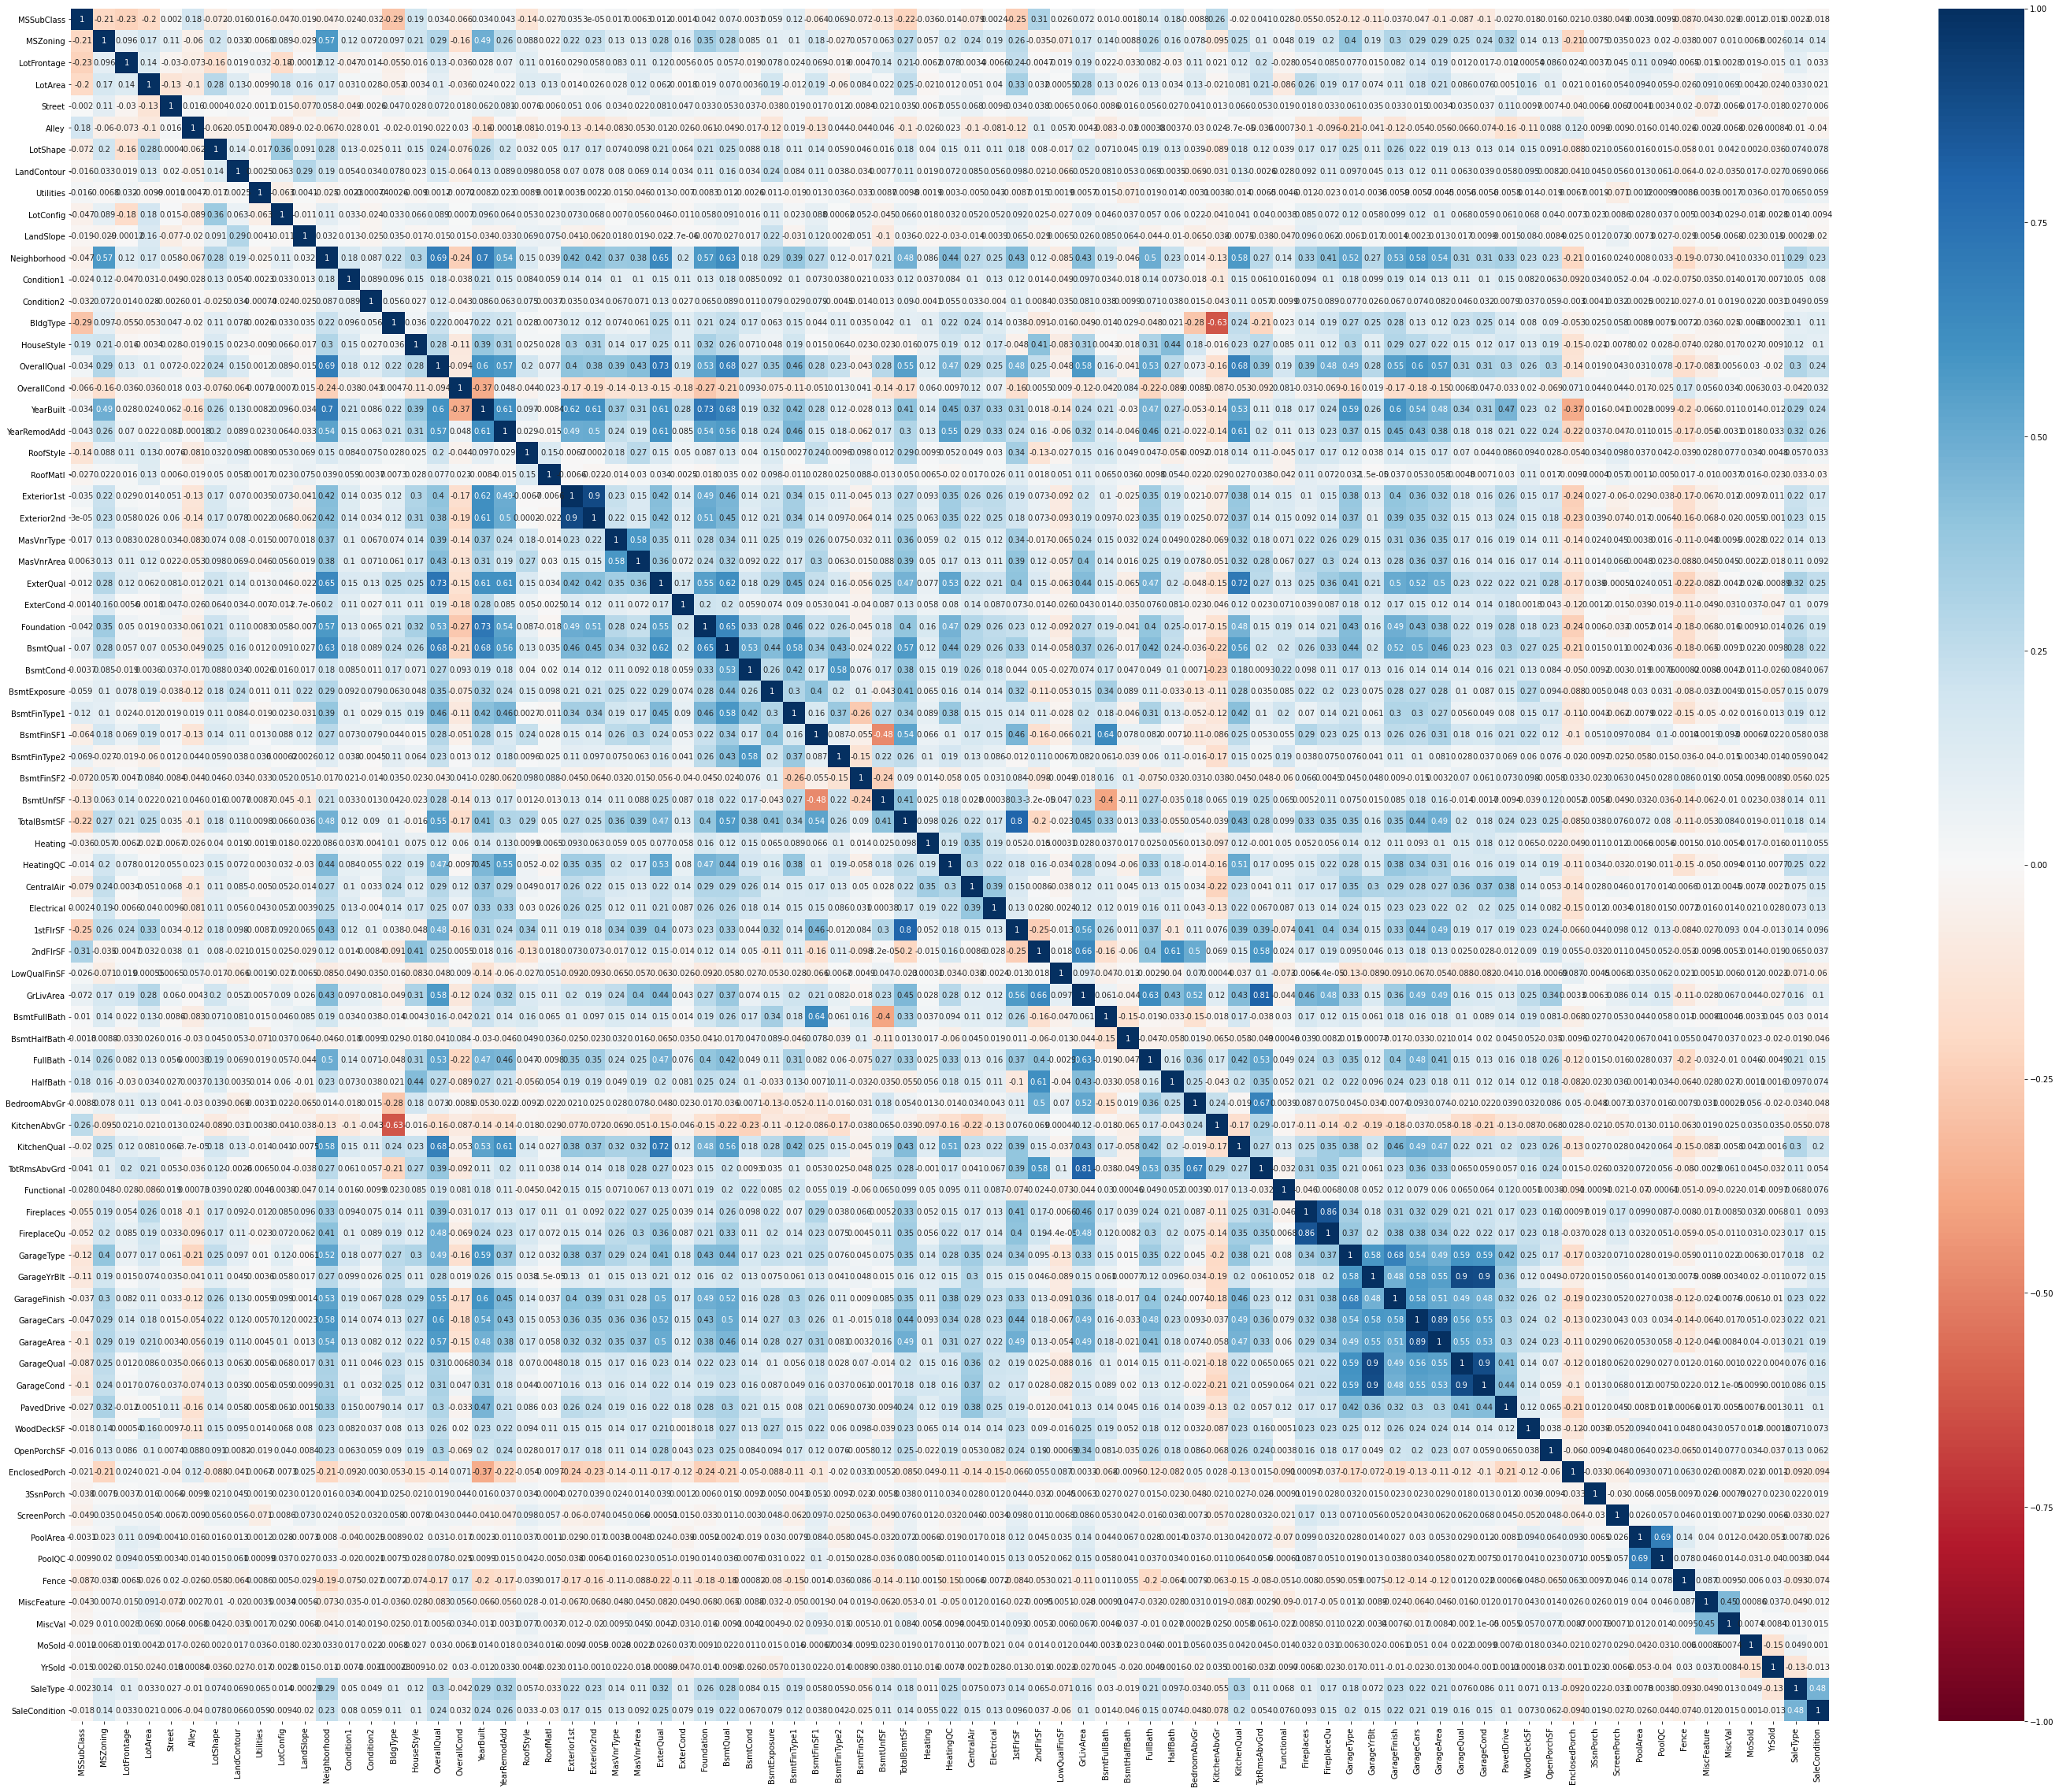

In [63]:
# Filling out missing MSZoning;
# Define the relationships b/w MSZoning and other features

plt.figure(figsize = (50,40))
sns.heatmap(combined[['MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']].corr(), annot = True, cmap = 'RdBu',
                xticklabels = True, vmin = -1, vmax = 1)
plt.show()

In [64]:
# Filling out missing MSZoning, based on correlating features ('Neighborhood', 'YearBuilt') and query subset:

for row in list(np.where(pd.isnull(combined['MSZoning'])==1)[0]):
    query_subset = combined[(combined['Neighborhood'] == combined.loc[row, 'Neighborhood']) &\
                            (combined['YearBuilt'] == combined.loc[row, 'YearBuilt'])]
    if len(query_subset) < 10:
        combined.loc[row,'MSZoning'] = np.nanmedian(combined.loc[:,'MSZoning'])
    else:
        combined.loc[row,'MSZoning'] = np.nanmedian(query_subset.loc[:,'MSZoning'])


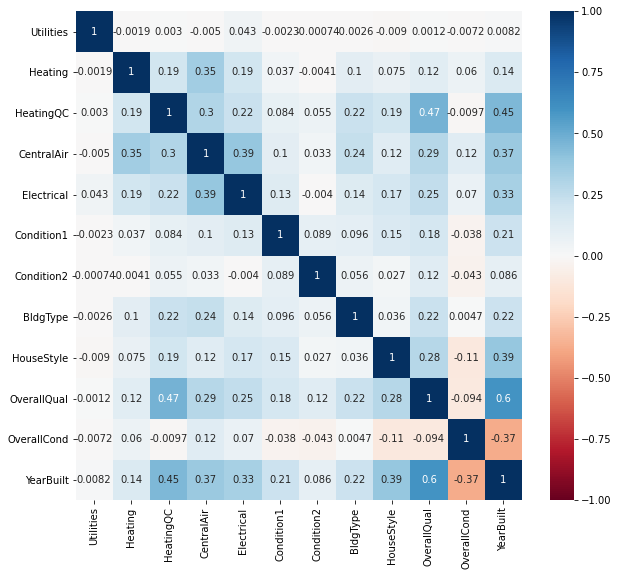

In [65]:
# Filling out missing utilities
# Define relationship b/w 'Utilities' and other related features 

plt.figure(figsize = (10,9))
sns.heatmap(combined[['Utilities','Heating', 'HeatingQC', 'CentralAir', 'Electrical','Condition1', 'Condition2','BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt']].corr(), annot = True, cmap = 'RdBu',
                xticklabels = True, vmin = -1, vmax = 1)
plt.show()

In [66]:
# Filling out missing utilities

for row in [1915, 1945]:
    # since no apparent correlations of the utilies with other features are found, feature's median is used   
    combined.loc[row,'Utilities'] = np.nanmedian(combined.loc[:,'Utilities'])
 

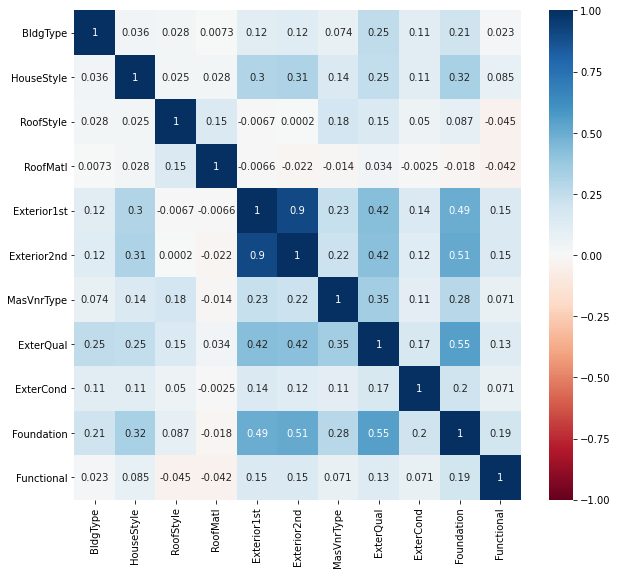

In [67]:
# Filling out missing Functional

# Define the relationship b/w 'Functional' and most close other features

plt.figure(figsize = (10,9))
sns.heatmap(combined[['BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'Functional']].corr(), annot = True, cmap = 'RdBu',
                xticklabels = True, vmin = -1, vmax = 1)
plt.show()

In [68]:
# Filling out missing functional using query subset and correlating features:
# 'Exterior1st', 'Exterior2nd','ExterQual','Foundation'

for row in list(np.where(pd.isnull(combined['Functional'])==1)[0]):
    query_subset = combined[(combined['Exterior1st'] == combined.loc[row, 'Exterior1st']) &\
                            (combined['Exterior2nd'] == combined.loc[row, 'Exterior2nd']) &\
                            (combined['ExterQual'] == combined.loc[row, 'ExterQual']) &\
                            (combined['Foundation'] == combined.loc[row, 'Foundation'])]
    if len(query_subset) < 10:
        combined.loc[row,'Functional'] = np.nanmedian(combined.loc[:,'Functional'])
    else:
        combined.loc[row,'Functional'] = np.nanmedian(query_subset.loc[:,'Functional'])


In [69]:
# Filling out 'Exterior1st', 'Exterior2nd'
# based on 'HouseStyle', 'ExterQual', 'Foundation'

query_subset = combined[(combined['HouseStyle'] == combined.loc[2151, 'HouseStyle']) &\
                        (combined['ExterQual'] == combined.loc[2151, 'ExterQual']) &\
                        (combined['Foundation'] == combined.loc[2151, 'Foundation'])] 
if len(query_subset) < 10:
    combined.loc[2151,'Exterior1st'] = np.nanmedian(combined.loc[:,'Exterior1st'])
    combined.loc[2151,'Exterior2nd'] = np.nanmedian(combined.loc[:,'Exterior2nd'])
else:
    combined.loc[2151,'Exterior1st'] = np.nanmedian(query_subset.loc[:,'Exterior1st'])
    combined.loc[2151,'Exterior2nd'] = np.nanmedian(query_subset.loc[:,'Exterior2nd'])


In [70]:
# Filling out missing BsmtFullBath,  BsmtHalfBath 

#combined.loc[2188, ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
#       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]  # shows there is no
                                                                                                   # basement 
combined.loc[2188,'BsmtFullBath'] = 0
combined.loc[2188,'BsmtHalfBath'] = 0

GarageType         2
GarageYrBlt     1977
GarageFinish       0
GarageCars       NaN
GarageArea       NaN
GarageQual         0
GarageCond         0
Name: 2576, dtype: object


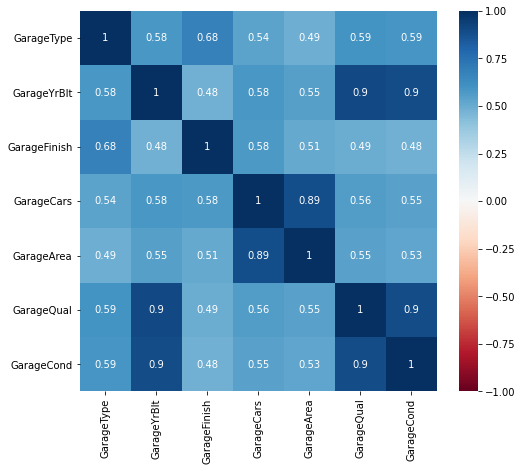

In [71]:
# Filling out GarageCars, GarageArea

print(combined.loc[2576, ['GarageType','GarageYrBlt', 'GarageFinish', 'GarageCars', 
                          'GarageArea', 'GarageQual','GarageCond']])

# Define the relationship b/w GarageCars, Area and most close other features

plt.figure(figsize = (8,7))
sns.heatmap(combined[['GarageType','GarageYrBlt', 'GarageFinish', 'GarageCars', 
                          'GarageArea', 'GarageQual','GarageCond']].corr(), annot = True, cmap = 'RdBu',
                xticklabels = True, vmin = -1, vmax = 1)
plt.show()

# Filling out missing values based on correlating features: 'GarageType', 'GarageYrBlt', 'GarageFinish', 
# 'GarageQual', 'GarageCond'

query_subset = combined[(combined['GarageType'] == combined.loc[2576, 'GarageType']) &\
                        (combined['GarageYrBlt'] == combined.loc[2576, 'GarageYrBlt']) &\
                        (combined['GarageFinish'] == combined.loc[2576, 'GarageFinish']) &\
                        (combined['GarageQual'] == combined.loc[2576, 'GarageQual']) &\
                        (combined['GarageCond'] == combined.loc[2576, 'GarageCond'])] 
if len(query_subset) < 10:
    combined.loc[2576,'GarageCars'] = np.nanmedian(combined.loc[:,'GarageCars'])
    combined.loc[2576,'GarageArea'] = np.nanmedian(combined.loc[:,'GarageArea'])
else:
    print(len(query_subset))
    combined.loc[2576,'GarageCars'] = np.nanmedian(query_subset.loc[:,'GarageCars'])
    combined.loc[2576,'GarageArea'] = np.nanmedian(query_subset.loc[:,'GarageArea'])


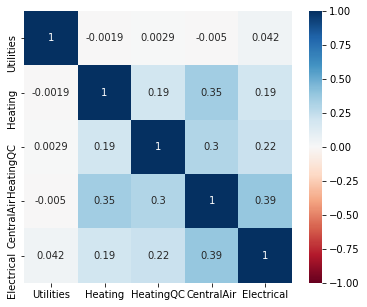

443


In [72]:
# Filling out Electrical
# Electrical (array([1379], dtype=int64),) 1

# Define the relationship b/w Electrical and most close other features

plt.figure(figsize = (6,5))
sns.heatmap(combined[['Utilities','Heating','HeatingQC', 'CentralAir', 'Electrical']].corr(), annot = True,\
            cmap = 'RdBu',xticklabels = True, vmin = -1, vmax = 1)
plt.show()

# Filling out Electrical based on 'Heating', 'HeatingQC','CentralAir' 

query_subset = combined[(combined['Heating'] == combined.loc[1379, 'Heating']) &\
                        (combined['HeatingQC'] == combined.loc[1379, 'HeatingQC']) &\
                        (combined['CentralAir'] == combined.loc[1379, 'CentralAir'])]
if len(query_subset) < 10:
    print('Less than 10')
    combined.loc[1379,'Electrical'] = np.nanmedian(combined.loc[:,'Electrical'])
else:
    print(len(query_subset))
    combined.loc[1379,'Electrical'] = np.nanmedian(query_subset.loc[:,'Electrical'])


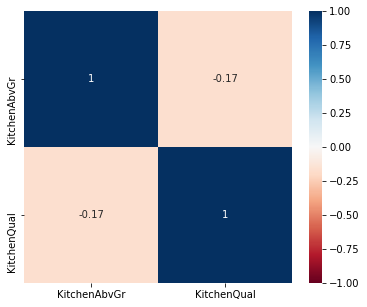

In [73]:
# Filling out Kitchen Quality

# Define the relationship b/w Kitchen Quality and most close other features

plt.figure(figsize = (6,5))
sns.heatmap(combined[['KitchenAbvGr','KitchenQual']].corr(), annot = True, cmap = 'RdBu',
                xticklabels = True, vmin = -1, vmax = 1)
plt.show()

# no apparent correlating features, filling out with feature's median
combined.loc[1555,'KitchenQual'] = np.nanmedian(combined.loc[:,'KitchenQual'])

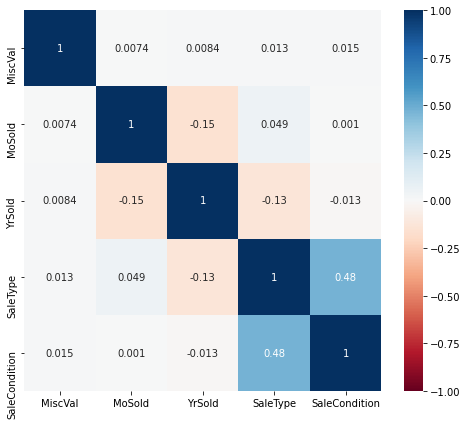

In [74]:
# Filling out SaleType

# Define the relationship b/w SaleType and most close other features

plt.figure(figsize = (8,7))
sns.heatmap(combined[['MiscVal', 'MoSold', 'YrSold', 'SaleType','SaleCondition']].corr(), annot = True, cmap = 'RdBu',
                xticklabels = True, vmin = -1, vmax = 1)
plt.show()
# no apparent correlating features, filling out with feature's median
combined.loc[2489,'SaleType'] = np.nanmedian(combined.loc[:,'SaleType'])

In [75]:
# Check now if there is any nans in /combined/

print(np.where(pd.isnull(combined)))

(array([], dtype=int64), array([], dtype=int64))


In [43]:
# Reference for the features, used in the mapping:

file = open('data_description.txt', 'r')
for line in file:
    print(line)

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER

        40	1-STORY W/FINISHED ATTIC ALL AGES

        45	1-1/2 STORY - UNFINISHED ALL AGES

        50	1-1/2 STORY FINISHED ALL AGES

        60	2-STORY 1946 & NEWER

        70	2-STORY 1945 & OLDER

        75	2-1/2 STORY ALL AGES

        80	SPLIT OR MULTI-LEVEL

        85	SPLIT FOYER

        90	DUPLEX - ALL STYLES AND AGES

       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER

       150	1-1/2 STORY PUD - ALL AGES

       160	2-STORY PUD - 1946 & NEWER

       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER

       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



MSZoning: Identifies the general zoning classification of the sale.

		

       A	Agriculture

       C	Commercial

       FV	Floating Village Residential

       I	Industrial

       RH	Residential High Density

       RL	Residential Low Density

       RP	Residential 

Features engineering

In [76]:
# Add some fetures, summarizing the data by themes

combined_prep = combined.drop(['Id'], axis = 1)
combined_prep['MSZoning_Neighborhood'] = combined_prep['MSZoning']+combined_prep['Neighborhood']
combined_prep['Street_Alley'] = combined_prep['Street'] + combined_prep['Alley']
combined_prep['LotLand'] = combined_prep['LotShape']+ combined_prep['LandContour']+combined_prep['LotConfig']+combined_prep['LandSlope']
combined_prep['tot_utilities'] = combined_prep['Utilities']+combined_prep['Heating']+combined_prep['HeatingQC']+combined_prep['CentralAir']+combined_prep['Electrical']
combined_prep['TwoConditions'] = combined_prep['Condition1']+combined_prep['Condition2']
combined_prep['Exterior'] = combined_prep['BldgType']+combined_prep['HouseStyle']+combined_prep['RoofStyle']+combined_prep['RoofMatl']+combined_prep['Exterior1st']\
+combined_prep['Exterior2nd']+combined_prep['MasVnrType']+combined_prep['ExterQual']+combined_prep['ExterCond']+combined_prep['Foundation']+combined_prep['Functional']
combined_prep['TotBsmtFin'] = combined_prep['BsmtFinType1']+combined_prep['BsmtFinType2']+combined_prep['BsmtCond']+combined_prep['BsmtQual']+combined_prep['BsmtExposure']
combined_prep['TotGarage'] = combined_prep['GarageType']+combined_prep['GarageFinish']+combined_prep['GarageQual']+combined_prep['GarageCond']
combined_prep['TotKitchen'] = combined_prep['KitchenQual']+combined_prep['KitchenAbvGr']


Check the skewness of data series and fix it

In [77]:
# Fix the skewness of the features:

# Check the skeweness of all features
skewed_feats = combined_prep.drop(['SalePrice'],axis=1).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print('Skew in numerical features:')
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness)

# Box Cox Transformation of highly skewed features (abs(skewness) > 0.75); 
# boxcox1p computes 1+x transformation; setting  λ=0  is equivalent to log1p used later for the target variable.

skewness = skewness[abs(skewness) > 0.75]
print('There are ', len(skewness), ' skewed numerical features to Box Cox transform')

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    combined_prep[feat] = boxcox1p(combined_prep[feat], lam)

# Check the skew of all numerical features after it's been corrected
skewed_feats = combined_prep.drop(['SalePrice'],axis=1).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness)    

Skew in numerical features:
                   Skew
MiscVal       21.947195
PoolQC        20.723994
PoolArea      16.898328
LotArea       12.822431
LowQualFinSF  12.088761
...                 ...
Functional    -4.400524
Condition2    -4.846648
Heating      -11.691000
Street       -15.500133
Utilities    -54.000003

[88 rows x 1 columns]
There are  88  skewed numerical features to Box Cox transform

Skew in numerical features: 

                   Skew
PoolQC        19.132694
PoolArea      15.119426
RoofMatl       9.466848
3SsnPorch      8.924822
LowQualFinSF   8.744143
...                 ...
Functional    -5.889123
Condition2   -12.144406
Heating      -13.393890
Street       -15.500133
Utilities    -54.000003

[88 rows x 1 columns]


In [78]:
# Have the train and test sets separated now

train = combined_prep[combined_prep['SalePrice'] != 'Unknown']
test = combined_prep[combined_prep['SalePrice'] == 'Unknown']

c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


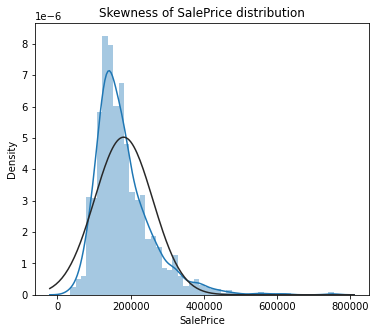

In [79]:
# Fix the skewness of the target = SalePrice:
# Visualize the skewness of the target

plt.figure(figsize=(6,5))
sns.distplot(train['SalePrice'], fit = norm)
plt.title('Skewness of SalePrice distribution')
plt.show()

mu = 12.02 and sigma = 0.40


c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'SalePrice distribution')

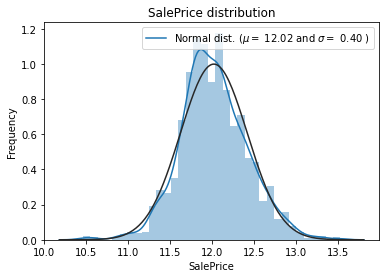

In [80]:
# Fix skewness of the target

# Use log1p which  applies log(1+x) to all elements of the column
# convert the target column into numerical (it's currently object)
train = train.astype({"SalePrice":'float64'})
train["SalePrice"] = np.log1p(train["SalePrice"])

# Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


Modelling: Ensemble of Ridge, Lasso, MLP regressor, LightGB, Gboost and Elastic Net

In [82]:
# Cross validate predictions by Ridge, tune the learner by GridSearchCV
kfold = KFold(n_splits=10, shuffle= True)
R = Ridge()
params = {'alpha':[0.01,0.1,0.5,1,5,10,100], 'normalize' : [True, False], 
          'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
tuned_R = GridSearchCV(R,param_grid=params, scoring="neg_mean_squared_log_error", verbose=1, n_jobs=3,cv=kfold)
tuned_R.fit(train.drop(['SalePrice'],axis=1), np.ravel(train['SalePrice']))
print('Best params', tuned_R.best_params_)
print('Best score',tuned_R.best_score_)

Fitting 10 folds for each of 98 candidates, totalling 980 fits
Best params {'alpha': 0.1, 'normalize': False, 'solver': 'auto'}
Best score -9.998703307754307e-05


c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [-1.37514511e-04 -1.32746420e-04 -1.37514511e-04 -1.34176677e-04
 -1.27342564e-04 -2.68684827e-01             nan -1.00282439e-04
 -1.00282439e-04 -1.00282439e-04 -1.04309836e-04 -1.02575283e-04
 -1.01768818e-04 -1.03080180e-04 -1.42895546e-04 -1.39274998e-04
 -1.42895546e-04 -1.47074121e-04 -1.49505581e-04             nan
 -2.28173308e-01 -9.99870331e-05 -9.99870331e-05 -9.99870331e-05
 -1.04032872e-04 -1.02343260e-04 -1.01869763e-04 -1.03073252e-04
 -1.30258171e-04 -1.29237952e-04 -1.30258171e-04 -1.31790340e-04
 -1.31857306e-04             nan             nan -1.00558871e-04
 -1.00558871e-04 -1.00558871e-04 -1.03721302e-04 -1.03024746e-04
 -1.02196597e-04 -1.03019851e-04 -1.31575557e-04 -1.31276500e-04
 -1.31575557e-04 -1.32552825e-04 -1.32624422e-04             nan
             nan -1.01092521e-04 -1.01092521e-04

In [83]:
# Add scaling of the data to the Ridge learner with best parameters; cross-validate

R = make_pipeline(StandardScaler(), Ridge(alpha=0.1, normalize=False, solver='auto'))
scores = cross_val_score(R, train.drop(['SalePrice'],axis=1), train[['SalePrice']], cv=kfold, scoring = "neg_mean_squared_log_error",
                         verbose= 1, n_jobs=3)
print(scores)
print(np.nanmean(scores))

[-1.11116791e-04 -1.52877690e-04 -1.10907935e-04 -7.78893113e-05
 -1.18341300e-04 -1.01963478e-04 -5.85350500e-05 -9.87125706e-05
 -6.07782936e-05 -1.77558096e-04]
-0.00010686805160414116


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


In [84]:
# Cross validate predictions by Lasso, tune the learner by GridSearchCV

L = Lasso()
params = {'alpha':[0.01,0.1,0.5,1,5,10,100,1000], 'normalize' : [True, False], 
          'warm_start': [True, False],'selection' : ['cyclic', 'random']}

tuned_L = GridSearchCV(L,param_grid=params, scoring="neg_mean_squared_log_error", verbose=1, n_jobs=3,cv=kfold)
tuned_L.fit(train.drop(['SalePrice'],axis=1), np.ravel(train['SalePrice']))
print('Best params', tuned_L.best_params_)
print('Best score',tuned_L.best_score_)


Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best params {'alpha': 0.01, 'normalize': False, 'selection': 'random', 'warm_start': False}
Best score -0.00014245075710292895


In [85]:
# Add scaling of the data to Lasso learner with best parameters; cross-validate

L = make_pipeline(StandardScaler(), Lasso(alpha=0.01, normalize= False, selection='random',warm_start=False))
scores = cross_val_score(L, train.drop(['SalePrice'],axis=1), train[['SalePrice']], cv=kfold, scoring = "neg_mean_squared_log_error",
                         verbose= 1, n_jobs=3)
print(scores)
print(np.mean(scores))


[-1.01422400e-04 -1.20660286e-04 -8.55119724e-05 -1.46569147e-04
 -7.69931232e-05 -7.61118736e-05 -9.68453291e-05 -9.35767447e-05
 -8.93712357e-05 -1.63451401e-04]
-0.00010505135142208557


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished


In [86]:
# Cross-validate Multi Layer Perceptron learner, tune by GridSearchCV

mlpR = MLPRegressor()

params = {'hidden_layer_sizes':[(100,), (10,10), (10,20,10)],
         'alpha':[0.01,0.1,0.5,1,5,10,100,1000],
         'activation':['relu','tanh'],
         'solver' : ['adam','lbfgs','sgd'],
         'learning_rate' : ['constant','adaptive']}

tuned_mlpR = GridSearchCV(mlpR,param_grid = params, cv=kfold, scoring = "neg_mean_squared_log_error", verbose=1, n_jobs=3)
tuned_mlpR.fit(train.drop(['SalePrice'],axis=1), np.ravel(train['SalePrice']))

print('Best score: ', tuned_mlpR.best_score_)
print('Best parameters: ', tuned_mlpR.best_params_)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [-2.06499894e-04 -1.17370450e-04 -1.95992770e-04 -2.24525813e-04
 -1.15932226e-04 -1.59076362e-04 -3.40086494e-04 -1.25532811e-04
 -4.62698619e-04 -2.91275684e-04 -1.33009069e-04 -3.66587032e-04
 -2.57508108e-04 -1.29621599e-04 -3.82868642e-04 -2.77586832e-04
 -1.24731091e-04 -5.11065663e-04 -2.12480249e-04 -1.15131775e-04
 -1.65302831e-04 -1.96121294e-04 -1.23658333e-04 -1.76765402e-04
 -3.25858878e-04 -1.18178931e-04 -3.91887117e-04 -2.18403386e-04
 -1.24657957e-04 -3.54580512e-04 -2.02404116e-04 -1.24216805e-04
 -5.06706498e-04 -2.40839475e-04 -1.37903833e-04 -3.38557019e-04
 -1.91871162e-04 -1.16079377e-04 -2.95074231e-04 -1.89144559e-04
 -1.13386425e-04 -6.51437423e-02 -3.05773553e-04 -1.33412876e-04
             nan -2.21723572e-04 -1.28002913e-04 -6.20074639e-04
 -2.07920117e-04 -1.29019754e-04 -4.51091361e-04

Best score:  -0.00010659832311726062
Best parameters:  {'activation': 'tanh', 'alpha': 5, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'lbfgs'}


c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [199]:
# Tuned_mlpR:

tuned_mlpR = MLPRegressor(activation= 'tanh', alpha= 5, hidden_layer_sizes= (10, 10), learning_rate= 'constant', solver= 'lbfgs')


In [201]:
# Cross validate Elastic Net learner, use the settings: alpha=0.0005,l1_ratio=.001 

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005,l1_ratio=.001, random_state=3))
scores = cross_val_score(ENet, train.drop(['SalePrice'],axis=1), train[['SalePrice']], cv=kfold, scoring = "neg_mean_squared_log_error",
                         verbose= 1, n_jobs=3)
print(scores)
print(np.mean(scores))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[-9.87169367e-05 -6.85910439e-05 -1.00055445e-04 -1.00907796e-04
 -1.19337801e-04 -8.26142797e-05 -1.13774532e-04 -9.47723638e-05
 -1.63131757e-04 -9.96278821e-05]
-0.00010415298377938601


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished


In [52]:
# Cross validate Gradient Boosting learner, use the given settings:

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
scores = cross_val_score(GBoost, train.drop(['SalePrice'],axis=1), train[['SalePrice']], cv=kfold, scoring = "neg_mean_squared_log_error",
                         verbose= 1, n_jobs=3)
print(scores)
print(np.mean(scores))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[-7.40717882e-05 -6.17917709e-05 -7.71260240e-05 -7.14705929e-05
 -9.95567916e-05 -1.15841312e-04 -9.74811000e-05 -8.14663882e-05
 -7.29637654e-05 -1.20899683e-04]
-8.72669215815488e-05


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.3min finished


In [202]:
# Gboost to use:

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [203]:
# Cross validate Light gradient boosting learner; use the following setting:

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
scores = cross_val_score(model_lgb, train.drop(['SalePrice'],axis=1), train[['SalePrice']], cv=kfold, scoring = "neg_mean_squared_log_error",
                         verbose= 1, n_jobs=3)
print(scores)
print(np.mean(scores))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[-6.92605886e-05 -7.79813505e-05 -8.58610834e-05 -1.01426782e-04
 -6.51670875e-05 -1.00546533e-04 -1.23275126e-04 -1.05390003e-04
 -5.75573789e-05 -1.05590348e-04]
-8.920562805283352e-05


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.5s finished


In [207]:
# Ensemble few learners using StackingRegressor:

estimators = [('Ridge',R),('Lasso', L),('tuned_mlpR',tuned_mlpR),('ENet',ENet),('GBoost',GBoost),('Lgb',model_lgb)]
SR = StackingRegressor(estimators)
SR.fit(train.drop(['SalePrice'],axis=1), train[['SalePrice']])
preds_sr = SR.predict(test.drop(['SalePrice'],axis=1))

# get the predicated prices back from being log transformed:
predictions_sr = np.expm1(preds_sr)

c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.428261752303236, tolerance: 0.023

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\alyon\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [208]:
# Place the predictions in required format and save

predictions = pd.DataFrame()
predictions['Id'] = list(range(1461,len(predictions_sr)+1461))
predictions['SalePrice'] = predictions_sr
predictions.to_csv('Predictions_output.csv', sep = ',', header=True, index=False)

[123537.16311133 159805.4004464  184467.49813836 ... 169687.11391324
 118166.01176376 207513.04740635]
        Id      SalePrice
0     1461  123537.163111
1     1462  159805.400446
2     1463  184467.498138
3     1464  195440.362437
4     1465  187565.144359
...    ...            ...
1454  2915   80408.824160
1455  2916   79335.990378
1456  2917  169687.113913
1457  2918  118166.011764
1458  2919  207513.047406

[1459 rows x 2 columns]
